In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [4]:
supervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/train/"
unsupervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/unsuper/images_gz2/"
batch_size = 32
train_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
train_data = ImageFolder(supervised_path, transform=train_trans)
train_loader = DataLoader(train_data, pin_memory=True, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))

unsuper_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
unsuper_data = ImageFolder(unsupervised_path, transform=train_trans)
unsuper_loader = DataLoader(unsuper_data, pin_memory=True, batch_size=batch_size, shuffle=True)

tensor([3, 6, 1, 5, 6, 0, 4, 1, 1, 5, 2, 1, 7, 3, 5, 3, 1, 7, 3, 0, 4, 2, 6, 3,
        0, 4, 4, 0, 0, 3, 6, 2])
tensor(3)


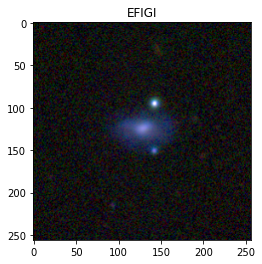

tensor(6)


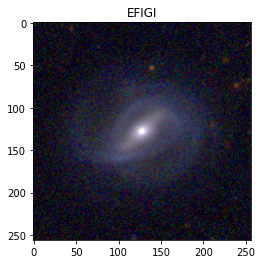

tensor(1)


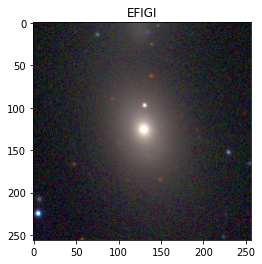

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


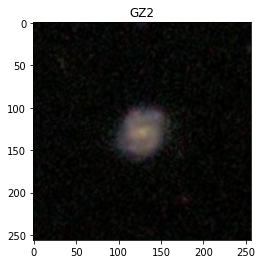

tensor(0)


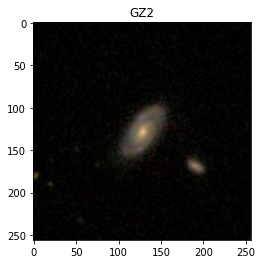

tensor(0)


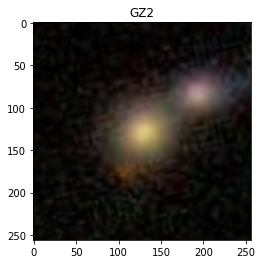

In [5]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.title('EFIGI')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()
    
un_images, un_labels = next(iter(unsuper_loader))
print(un_labels)
for i in np.arange(3):
    print(un_labels[i])
    plt.figure(i)
    plt.title('GZ2')
    plt.imshow(un_images[i].permute(1, 2, 0))
    plt.show()

In [6]:
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, 3, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 4, 3, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         # decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(4, 16, 2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, 2, stride=2),
#             nn.Sigmoid()
#         )
# #         self.fc1 = nn.Linear(2, 4)
# #         self.fc2 = nn.Linear(4, 4)
#     def forward(self, x):
# #         x = self.encoder(x)
# #         x = x.view(len(x), -1) # flatten
# #         encoded = self.fc1(x)
        
# #         x = F.relu(self.fc2(encoded))
# #         x = x.view(-1, 4, 1, 1)
# #         x = self.decoder(x)
#         code = self.encoder(x)
#         output = self.decoder(code)
#         return code, output
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        output = self.decoder(codes)
        
        return codes, output

In [7]:
model = AutoEncoder()
model = model.to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [8]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

In [ ]:
n_epochs = 1
train_loss_record = []
val_loss_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for img, i in tqdm(unsuper_loader):
        img, i = img.to(device), i.to(device)
        optimizer.zero_grad()
        _, reconstruct = model(img)
        loss = loss_func(reconstruct, img)
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.item()/len(train_loader))
        print(f'[Train | {epoch+1}/{n_epochs} ] loss: {loss.item():.4f}', end='\r')
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}")
    train_loss_record.append(train_loss)
torch.save(model, 'semi.pkl')
#     model.eval()
#     with torch.no_grad():
#         for i, img in tqdm(enumerate(val_loader)):
#             img = img.to(device)
#             _, reconstruct = model(img)
#             loss = loss_func(reconstruct, img)
# #             loss.backward()
#             val_loss += (loss.item()/len(val_loader))
#             if loss < min_loss:
#                 min_loss = loss
#                 print(f'saving model with loss: {loss:.4f}')
#                 torch.save(model, 'E_I_S_new.pkl')
#         print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
#     val_loss_record.append(val_loss)

In [ ]:
color = ['red', 'blue', 'black', 'orange', 'green', 'pink', 'purple', 'gray']
def show2d(x, y, mode):
    print(len(x))
    plt.title(mode)
    for i in range(len(x)):
        plt.scatter(x[i][0], x[i][1], color=color[y[i]])
    plt.show()
def show3d(x, y, mode):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.title(mode)
    for i in range(len(x)):
        plt.scatter(x[i], x[i], x[i], color=color[y[i]])
    plt.show()

In [1]:
!nvidia-smi

Wed Aug 25 18:43:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   61C    P2   205W / 215W |   7391MiB /  7981MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
model = torch.load('semi.pkl')
reduced_dim = 8
device = 'cpu'
model.eval()
latent_vec = torch.tensor([]).to(device, dtype=torch.float)
for img, x in unsuper_loader:
#     print("predict %d / %d" % (idx, len(train_loader)) , end='\r')
    img = img.to(device, dtype=torch.float)
    latent, r = model(img)
    latent_vec = torch.cat((latent_vec, latent), dim=0)

latent_vec = latent_vec.cpu().detach().numpy()
print(latent_vec.shape)
# shape = (40000, latent_dim)

# tsne = TSNE(n_components=reduced_dim, verbose=1, perplexity=50, n_iter=n_iter)
# latent_vec = tsne.fit_transform(latent_vec)

pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
latent_vec = pca.fit_transform(latent_vec)

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=100).fit(latent_vec)
print(kmeans.labels_)